# Import packages

In [1]:
import pandas as pd
import sys
sys.path.append('../')

from aqc_utils.molecule import molecule
from aqc_utils.slurm_manager import slurm_manager
from aqc_utils.helper_classes import slurm_status
from dft_descriptors import prepocessing as pp
import logging
logging.basicConfig(level=logging.INFO)

# Initialize the slurm manager

Slurm manager is going to manage what jobs you have currently running, or created. It caches your information, so you can kill the notebook, turn-off your computer, go on vacation, and pick it up later. It will remember which jobs you haven't retrieved from the cluster, etc.

Note: it won't ask you for login unless you execute a method that requires remote access

In [2]:
sm=slurm_manager(user='jschleinitz', host='hermite.chimie.ens.fr')
sm.connect()

INFO:aqc_utils.slurm_manager:Creating connection to hermite.chimie.ens.fr as jschleinitz
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_8.2p1)
INFO:paramiko.transport:Authentication (password) successful!
INFO:aqc_utils.slurm_manager:Connected to hermite.chimie.ens.fr as jschleinitz is True.


# Provide smiles string(s)
and copy into them into my_smiles variable. It's a list of strings (a Python list can be of any size), the smiles are extracted for the csv resulting form the step 2 numbering the molecules.

In [3]:
react_nb = pd.read_csv("../data_csv/Data_test11032021.csv", sep=',')
react_nb = pp.preprocess(react_nb)

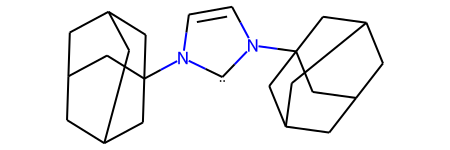

In [13]:
smiles = ["[C]1N(C23CC4CC(CC(C4)C2)C3)C=CN1C12CC3CC(CC(C3)C1)C2"]
from rdkit import Chem
Chem.MolFromSmiles(smiles[0])

# Initialize the molecules and generate conformations
We will use some for loops to loop over the smiles, only one conformation will be taken for each molecules in this work

In [5]:
mols = []
for smile in smiles:
    mols.append(molecule(smile, max_num_conformers=1))

INFO:aqc_utils.molecule:Initializing molecule with canonical smiles: C1C2CC3CC1CC(C2)(C3)N1C=CN([C]1)C12CC3CC(C2)CC(C1)C3
INFO:aqc_utils.molecule:Creating initial geometry with option 'best'.
INFO:aqc_utils.molecule:Initial geometry created successfully.


###### Draw some molecules

In [6]:
#mols[0].draw(0)

# Create gaussian job for each conformation

In [7]:
for mol in mols:
    sm.create_jobs_for_molecule(mol, workflow_type="equilibrium")

In [8]:
sm.get_job_stats(split_by_can=True)

status,done,failed,incomplete,submitted,uploaded
can,,,,,
BrB(Br)Br,0,0,0,0,1
Br[Mg]C1CCCCC1,0,0,0,0,1
Br[Mg]Cc1ccccc1,0,0,0,0,1
Br[Mg]c1c(C)cc(cc1C)C,0,0,1,0,0
C(Oc1ccccc1)Oc1ccccc1,0,1,0,0,0
...,...,...,...,...,...
c1ccc(cc1)c1ccc2c(c1)c1cc(ccc1o2)c1ccccc1,0,1,0,0,0
c1ccc2c(c1)OCC2,0,1,0,0,0
c1ccc2c(c1)cc1c(c2)oc2c1cc1ccccc1c2,0,1,0,0,0


In [9]:
sm.submit_jobs()

INFO:aqc_utils.slurm_manager:Submitting 0 jobs.


In [10]:
sm.squeue()

,RUNNING
jobs,6


In [11]:
for job in sm.get_jobs():
    if str(sm.get_jobs()[job].status) == 'slurm_status.done':
        print(sm.get_jobs()[job].base_name)

C20H28O2_1cb0_conf_1


In [93]:
job

'447581cd9c6bf05e9ba87c3a578b7d6d'

In [94]:
job_all = sm.get_jobs()[job]

In [95]:
sm.get_job_stats()

status,done,failed,incomplete,submitted,uploaded
jobs,1,343,3,5,93


In [87]:
str(job_all.status)

'slurm_status.created'

In [88]:
job_all.base_name

'C12H13NO2_b9f2_conf_0'